# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведена следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.012776561189455

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    n = X.shape[0]
    bootstrap_index = np.random.choice(n, size=(num_runs, n), replace=True)    # indexes of objects in each bootstrap set
    predictions = np.zeros((n, num_runs))    # matrix of predictions
    pred_mask = np.zeros((n, num_runs))
    
    for j in range(num_runs):
        Xj = X[bootstrap_index[j]]
        yj = y[bootstrap_index[j]]
        
        out_of_bag_index = list(set(range(n)) - set(bootstrap_index[j]))    # indexes of out-of-bag objects
        pred_mask[out_of_bag_index, j] = 1
        
        model = regressor.fit(Xj, yj)
        predictions[out_of_bag_index, j] = model.predict(X[out_of_bag_index])
    
    in_out_of_bag = np.where(np.sum(pred_mask, axis=1) != 0)    # keep objects with predictions only
    predictions = predictions[in_out_of_bag]    
    y_new = y[in_out_of_bag]
    pred_mask = pred_mask[in_out_of_bag]
    
    bias = np.mean((np.sum(predictions, axis=1) / np.sum(pred_mask, axis=1) - y_new) ** 2)
    
    var_x = np.zeros(pred_mask.shape[0])
    for j in range(num_runs):
        cur_preds = predictions[pred_mask[:,j] != 0,:]    # to compute variances for models with present predictions for each object
        var_x[pred_mask[:,j] != 0] += (cur_preds[:,j] - (np.sum(cur_preds, axis=1) / np.sum(pred_mask[pred_mask[:,j] != 0], axis=1))) ** 2
    variance = np.mean(var_x / np.sum(pred_mask, axis=1))

    error = (pred_mask * (predictions - y_new[:, np.newaxis]) ** 2).sum() / pred_mask.sum()
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
bvd = []
for regressor in regressors:
    bvd.append(compute_bias_variance(regressor, X, y))
    print(type(regressor).__name__, ': bias = %.4f, variance = %.4f, error = %.4f' % bvd[-1])

LinearRegression : bias = 23.6807, variance = 0.9018, error = 24.5125
DecisionTreeRegressor : bias = 10.2824, variance = 12.8049, error = 23.1188
RandomForestRegressor : bias = 10.7618, variance = 2.2668, error = 13.0404


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

*Для линейной регрессии наблюдаем высокое смещение с низким разбросом. Это соответствует тому, что линейная модель является простой и часто выдаёт предсказания, неблизкие от истинных значений, разброс при этом небольшой (при разных выборках выходят приблизительно близкие друг к другу значения). Решающие деревья работают точнее (ниже смещение), однако поскольку они чувствительны к обучающим выборкам, при разных выборках получаются разные ответы (большой разброс). Случайный лес усредняет несколько решающих деревьев, из-за чего смещение остаётся похожим, однако из-за использования нескольких деревьев, которые на каждом шаге выбирают оптимальный предикат из случайного подмножества возможных предикатов, модель становится менее чувствительной к изменениям в обучающей выборке (ниже разброс).*

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

*В теории бэггинг может уменьшить разброс алгоритма в $n$ раз, где $n$ - выбранное количество базовых моделей в композиции.* 

$$variance(bagging(b_1,...,b_n)(x)) = \frac{1}{n} variance(b_1(x)) + \frac{n(n-1)}{n^2}\mathbb{E}_{x}\left[\mathbb{E}_{X}(\mu_1(X)(x) - \mathbb{E}_X\mu_1(X)(x))(\mu_2(X)(x) - \mathbb{E}_X\mu_2(X)(x))\right]$$

*При выбранном значении $n = 10$ можем заметить, что для линейной модели разброс не изменился (примерно равен 1 с и без бэггинга), для решающего дерева разброс уменьшился примерно в 3 раза (12.8 без бэггинга и 3.4 с бэггингом), для случайного леса разброс уменьшился меньше чем в 2 раза (с 2.3 до 1.4). Так как разброс беггинга также состоит из ковариации двух базовых моделей, при значительных значениях ковариации моделей разброс может не уменьшиться в $n$ раз (а может и увеличиться). Это и наблюдаем в полученных результатах - при линейной регрессии из-за простоты модели ковариация двух моделей, обученных на разных выборках, велика, разброс не уменьшается, при решающих деревьях и случайном лесе ковариация меньше, но недостаточно низкая, чтобы было достигнуто уменьшение разброса в $n$ раз.*

In [9]:
from sklearn.ensemble import BaggingRegressor
bagging_bvd = []
print('Bagging:')
for regressor in regressors:
    cur_bagging = BaggingRegressor(base_estimator=regressor, n_estimators=10)
    bagging_bvd.append(compute_bias_variance(cur_bagging, X, y))
    print(type(regressor).__name__, ': bias = %.4f, variance = %.4f, error = %.4f' % bagging_bvd[-1])

Bagging:
LinearRegression : bias = 23.7400, variance = 1.0546, error = 24.9771
DecisionTreeRegressor : bias = 10.6661, variance = 3.3540, error = 14.1103
RandomForestRegressor : bias = 11.7345, variance = 1.3932, error = 13.1029


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
from sklearn.model_selection import train_test_split
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    n = X_train.shape[0]
    
    if ax is None:    # modified to plot subplots
        ax = plt.gca()
    ax.set_title(title)
    ax.set(xlabel='test objects', ylabel='prediction')
    
    predictions = np.zeros((num_test_objects, num_runs))
    bootstrap_indexes = np.random.choice(n, size=(num_runs, n))
    for i in range(num_runs):
        model = regressor.fit(X_train[bootstrap_indexes[i]], y_train[bootstrap_indexes[i]])
        predictions[:,i] = model.predict(X_test)
        ax.scatter(range(num_test_objects), model.predict(X_test), color = 'green')
    ax.scatter(range(num_test_objects), y_test, s=100, color = 'black', marker='x', label='True value')
    ax.legend()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

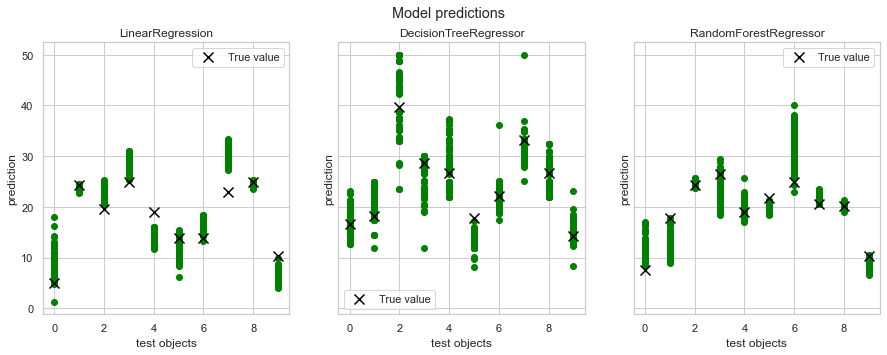

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
fig.suptitle('Model predictions')
for i in range(3):
    regressor = regressors[i]
    plot_predictions(regressor, X, y, title=type(regressor).__name__, ax=ax[i])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

*Для линейной модели можно заметить, что столбцы предсказаний короткие, однако часто не пересекающиется с верными ответами, это соответствует низкому разбросу и высокому смещению модели. Для решающих деревьев можем заметить, что предсказания делаются точнее, чем в линейной модели (а значит, смещение ниже), однако длина столбцов больше, т.е. разброс предсказаний становится выше. Для случайного леса можем заметить, что разброс, как и в линейной модели, небольшой (видно по длине столбцов предсказаний), а также смещение невелико - предсказания, как правило, близки к верному ответу.*

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

*Нарисовала на всякий графики-heatmap по общей сетке по max_features и max_depth одновременно, а также графики для этих признаков по-отдельности (остальные гиперпараметры моделей по умолчанию).*

In [17]:
max_depth_grid = range(1,10 + 1)
max_features_grid = range(1, X.shape[1] + 1)
grid_res = []
for depth in max_depth_grid:
    for ft in max_features_grid:
        grid_res.append(compute_bias_variance(DecisionTreeRegressor(max_depth=depth, max_features = ft), X, y))

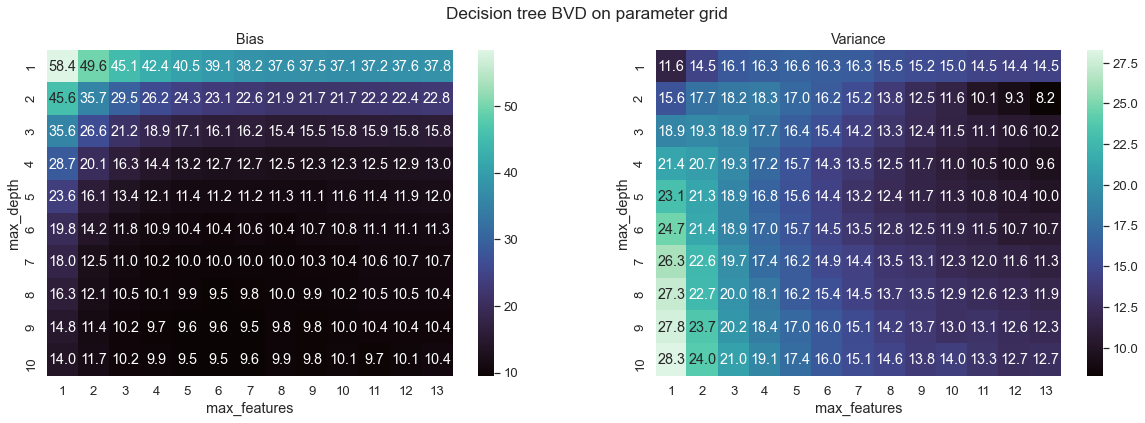

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
fig.suptitle('Decision tree BVD on parameter grid')

sns.set(font_scale=1.2)
ax[0].set_title('Bias')
ax[0].set_yticks(max_depth_grid)
sns.heatmap(np.reshape(list(map(lambda x: x[0], grid_res)), (10, X.shape[1])), ax=ax[0],
            annot=True, cmap='mako', fmt='.1f', yticklabels=max_depth_grid, xticklabels=max_features_grid)
ax[0].set(xlabel='max_features', ylabel='max_depth')
ax[1].set_title('Variance')
sns.heatmap(np.reshape(list(map(lambda x: x[1], grid_res)), (10, X.shape[1])), ax=ax[1],
            annot=True, cmap='mako', fmt='.1f', yticklabels=max_depth_grid, xticklabels=max_features_grid)
ax[1].set(xlabel='max_features', ylabel='max_depth')
plt.show()

In [12]:
depth_bvd = []
for depth in max_depth_grid:
    depth_bvd.append(compute_bias_variance(DecisionTreeRegressor(max_depth = depth), X, y))

features_bvd = []
for ft in max_features_grid:
    features_bvd.append(compute_bias_variance(DecisionTreeRegressor(max_features = ft), X, y))

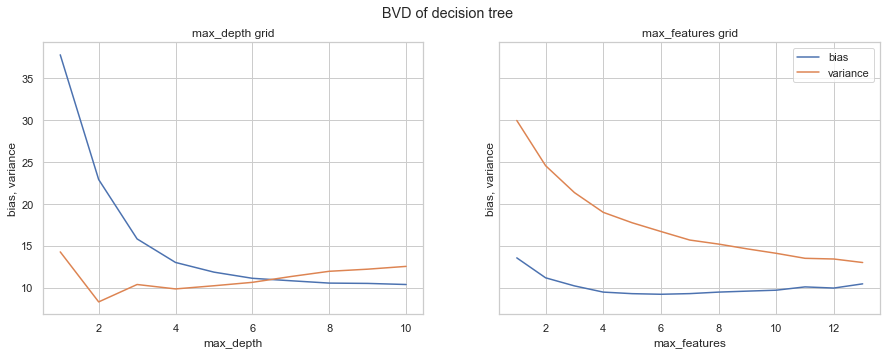

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('Bias and variance on parameter grid')

ax[0].set_title('max_depth grid')
ax[0].set(xlabel='max_depth', ylabel='bias, variance')
ax[0].plot(max_depth_grid, list(map(lambda x: x[0], depth_bvd)), label='bias')
ax[0].plot(max_depth_grid, list(map(lambda x: x[1], depth_bvd)), label='variance')

ax[1].set_title('max_features grid')
ax[1].set(xlabel='max_features', ylabel='bias, variance')
ax[1].plot(max_features_grid, list(map(lambda x: x[0], features_bvd)), label='bias')
ax[1].plot(max_features_grid, list(map(lambda x: x[1], features_bvd)), label='variance')

plt.legend(facecolor='w')
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
n_estimators_grid = 2 ** np.arange(1, 10)
rf_bvd = []
gb_bvd = []

for n_est in n_estimators_grid:
    rf_bvd.append(compute_bias_variance(RandomForestRegressor(n_estimators = n_est), X, y))
    gb_bvd.append(compute_bias_variance(GradientBoostingRegressor(n_estimators = n_est), X, y))

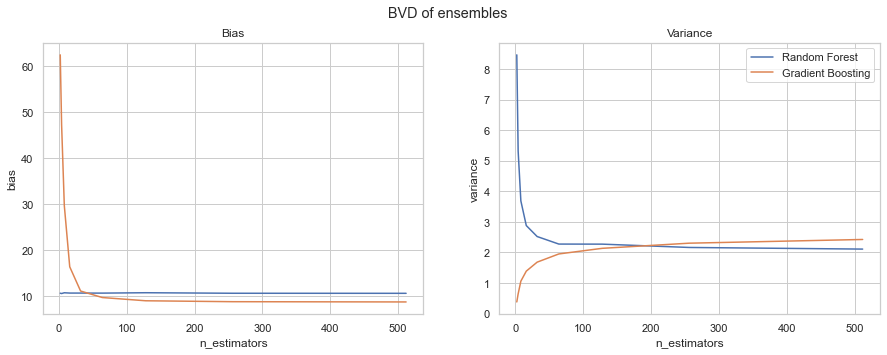

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('BVD of ensembles')

ax[0].set_title('Bias')
ax[0].set(xlabel='n_estimators', ylabel='bias')

ax[1].set_title('Variance')
ax[1].set(xlabel='n_estimators', ylabel='variance')

ax[0].plot(n_estimators_grid, list(map(lambda x: x[0], rf_bvd)), label='Random Forest')
ax[0].plot(n_estimators_grid, list(map(lambda x: x[0], gb_bvd)), label='Gradient Boosting')

ax[1].plot(n_estimators_grid, list(map(lambda x: x[1], rf_bvd)), label='Random Forest')
ax[1].plot(n_estimators_grid, list(map(lambda x: x[1], gb_bvd)), label='Gradient Boosting')

plt.legend(facecolor='w')
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

*По графикам 9 номера видим:*
- *с увеличением параметра `max_depth` смещение уменьшается, поскольку чем глубже разрешается строить дерево, тем точнее будет разделение объектов и ниже смещение;* 
- *аналогично и с параметром `max_features`: чем полнее множество предикатов, из которых выбирается оптимальный, тем точнее будет построение дерева (при небольшом значении `max_features` дерево может обучиться на плохих признаках, что приведёт к высокому смещению);* 
- *разброс с увеличением допустимой глубины дерева увеличивается, объяснить это можно тем, что чем глубже строится дерево, тем чувствительнее оно к изменениям обучающей выборки, из-за чего и увеличивается разброс ответов;* 
- *с увеличением допустимого количества признаков, из которых выбирается оптимальный предикат, значение разброса уменьшается, что можно объяснить тем, что при небольшом подмножестве предикатов (из которых выбирается оптимальный) дерево будет больше подстраиваться под обучающую выборку (чем если бы предикат выбирался из всех возможных).*

*По графикам 10 номера можно заметить:*
- *смещение для случайного леса остаётся примерно на одном уровне (10) при разных значениях `n_estimators`. Объяснить это можно тем, что при композиции деревьев смещение остаётся таким же, как и смещение одного дерева, и не зависит от количества деревьев;*
- *при градиентном бустинге же наблюдается резкий спад смещения (при `n_estimators = 2` модель подстраивается под ошибку только один раз, а поскольку базовая модель проста, ответ получается неточным и смещение высоким), после чего значение разброса уменьшается и выходит на асимптоту (при большем количестве базовых моделей общая модель лучше подстраивается под ошибки на каждом шаге, после некоторого шага бустинга ошибка уже практически не изменяется, из-за чего график смещения остаётся на одном уровне);*
- *для разброса же на случайном лесе наблюдается уменьшение до стабилизации. Разброс значительно уменьшается при случайном лесе, поскольку при `n_estimators` = 2 работа случайного леса похожа на работу решающего дерева (у которого получается высокий разброс), однако чем больше количество деревьев в модели леса, тем меньше корреляция базовых моделей-деревьев (из-за выбора предикатов из подмножетсва признаков) и разброс уменьшается в несколько раз относительно базовой модели (одного решающего дерева) (в формуле разброса для бэггинга (см. задание 4) видно, что разброс состоит из разброса базовой модели, поделённой на количество моделей, и ковариации базовых моделей);*
- *при градиентном бустинге на неглубоких деревьях модель строит композицию, ошибка которой выходит на асимптоту (см. график смещения), после чего подстраивается уже под шум, из-за чего и можно наблюдать переобучение (увеличение значения разброса). Происходить это может потому, что базовые модели в бустинге являются простыми (неглубокие деревья) и плохо приближают вектор антиградиента, из-за чего могут свести бустинг к случайному блужданию.*